# Average Annual Daily Traffic (Current)

Minnesota Department of Transport (MnDoT)

Source: https://gisdata.mn.gov/dataset/trans-aadt-traffic-segments

Metadata: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dot/trans_aadt_traffic_segments/metadata/metadata.html

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import shutil # For deleting folders
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation

# Visualization

import matplotlib.pyplot as plt # Basic Plotting
import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization

In [2]:
### Definitions

files_before = os.listdir() # Take note of what's in current directory so it won't be deleted at the end.

cwd = os.getcwd() # Current Working Directory

# Forward or back slashs for filepaths? <- Not sure here. Only know Windows & Linux

if platform == "linux" or platform == "linux2":
    slash = '/'
elif platform == 'win32':
    slash = '\\'

def extract_zip_from_url(urls=None):
    '''Extract a zipfile from the internet and unpack it in working directory.
    Takes a single url (string) or a list of urls.'''
    
    if type(urls) == str: # Single url
        url = urls
        response = urllib.request.urlopen(url) # Get a response
        zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
        zip_folder.extractall() # Extract files
        zip_folder.close()
    
    elif type(urls) == list: # List of urls
        for url in urls:
            response = urllib.request.urlopen(url) # Get a response
            zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
            zip_folder.extractall() # Extract files
            zip_folder.close()
    else:
        print('Error Extracting: Invalid Input')

def clip_to_extent(gdf):
    '''This function returns the dataset clipped to the boundaries of Minneapolis and the boundary itself.
    Warning: This function will access the geojson of Minneapolis from GitHub if it's not in the current working directory or local Boundary folder.
    See this link for more info: https://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb'''
    
    # Look for mpls_boundary
    
    cwd = os.getcwd() # Current working directory

    os.chdir('..') # Bump up one directory

    if 'mpls_boundary.shp' in os.listdir(cwd): # Boundary shapefile in the current working directory
        mpls_boundary = gpd.read_file(r'mpls_boundary.shp') # Load extent as GeoDataFrame

    elif 'mpls_boundary.geojson' in os.listdir(cwd): # Boundary json in the current working directory
        mpls_boundary = gpd.read_file(r'mpls_boundary.geojson') # Load extent as GeoDataFrame

    elif 'Boundary' in os.listdir(): # Boundary folder on computer
        if 'mpls_boundary.geojson' in os.listdir('Boundary'): # Is the json there?
            path = 'Boundary' + slash + 'mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(path)

        else:
            print('''Can't find mpls_boundary.geojson. Accessing from GitHub.\n 
            See this link for more info: \n\nhttps://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb''')
            url = 'https://raw.githubusercontent.com/RwHendrickson/MappingGZ/main/Prototype/Notebooks/CleaningData/Boundary/mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(url) # Load extent as GeoDataFrame
    else:
            print('''Can't find mpls_boundary.geojson. Accessing from GitHub.\n 
            See this link for more info: \n\nhttps://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb''')
            url = 'https://raw.githubusercontent.com/RwHendrickson/MappingGZ/main/Prototype/Notebooks/CleaningData/Boundary/mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(url) # Load extent as GeoDataFrame


    os.chdir(cwd) # Go back to current working directory
    
    if gdf.crs != 'EPSG:26915': # Ensures gdf is in the same CRS
        gdf = gdf.to_crs('EPSG:26915')
    
    clipped = gpd.clip(gdf, mpls_boundary) # Clip
    
    return clipped, mpls_boundary

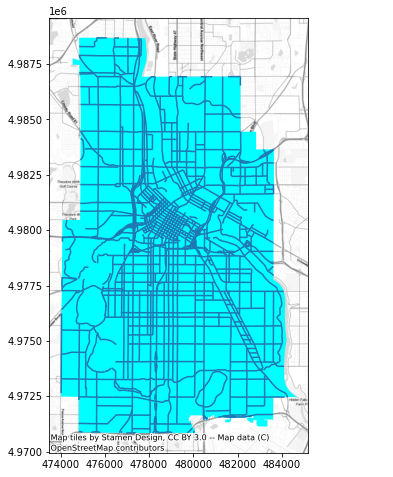

In [3]:
### Load, Clip, & Plot

if 'mpls_aadt.geojson' in os.listdir(): # If already in directory
    
    mpls_aadt = gpd.read_file('mpls_aadt.geojson')
    _, mpls_bound = clip_to_extent(mpls_aadt) # Get study extent from clip function
    
    
else: # Download & Clip
    
    ## AADT for all of Minnesota - Downloaded from MN GeospatialCommons gisdata.mn.gov  (~ 5mb)
    
    print('Downloading AADT from GeoSpatialCommons (~5mb)')

    url = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dot/trans_aadt_traffic_segments/shp_trans_aadt_traffic_segments.zip'
    extract_zip_from_url(url)
    
    mn_aadt = gpd.read_file('Annual_Average_Daily_Traffic_Segments_in_Minnesota.shp') # Load as GeoDataFrame
    
    mpls_aadt, mpls_bound = clip_to_extent(mn_aadt) # Clip MN data to Extent of study
    

# Plotting

f, ax = plt.subplots(1,1,figsize = (8,8))

mpls_bound.plot(ax = ax,
                cmap = 'cool')
mpls_aadt.plot(ax = ax)

contextily.add_basemap(ax = ax, 
                       crs = mpls_bound.crs, 
                       source = contextily.providers.Stamen.TonerLite
                      )

In [4]:
# Save mpls_aadt as zipped shapefile & geojson

if 'mpls_aadt.zip' not in files_before:

    mpls_aadt.to_file(r'mpls_aadt.shp') # Save shapefile

    cwd = os.getcwd() # Current Working Directory

    zipped = zipfile.ZipFile(cwd + slash + 'mpls_aadt.zip', 'w', zipfile.ZIP_DEFLATED) # Initialize folder

    for root, dirs, files in os.walk(cwd):
        for file in files:
            if 'mpls_aadt' in file and file != 'mpls_aadt.zip': # Locate Shapefiles
                zipped.write(file) # Write to Zip

    zipped.close() # Close zip
    
if 'mpls_aadt.geojson' not in files_before:
    mpls_aadt.to_file(r'mpls_aadt.geojson', driver='GeoJSON') # Save geojson

In [5]:
# Careful with this cell!

# Removes All files in working directory besides this notebook, the zipped shapefile,
 # the geojson, and files in the working directory before running the notebook

for file in os.listdir(cwd): # Loop over files
    if file in files_before: # Keep files from before
        pass
    elif 'mpls_aadt.zip' == file or 'mpls_aadt.geojson' == file: # Keep zip & json
        pass
    elif '.ipynb' in file: # Keep notebooks
        pass
    elif 'metadata' in file: # Keep metadata but delete preview
        os.remove(file + slash + 'preview.jpg')
    else:
        os.remove(file) # Remove all others